In [2]:
import json
import tensorflow as tf
import csv
import random
import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers


embedding_dim = 100
maxlen = 16
truncating='post'
padding='post'
oov_token = "<OOV>"
training_size = 160000
test_portion =.1

In [3]:
df = pd.read_csv('https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv', header=None)
df.columns = ['label', 'id', 'date', 'query', 'name', 'sent']
df['label'] = df[['label']].applymap(lambda x: 0 if x==0 else 1)

In [4]:
corpus_tuples_list = list(df[['sent', 'label']].itertuples(index=False, name=None))
corpus = [list(list_item) for list_item in corpus_tuples_list]
num_sentences = len(corpus)

In [5]:
print(num_sentences)
print(len(corpus))
print(corpus[1])

# Expected Output:
# 1600000
# 1600000
# ["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]

1600000
1600000
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", 0]


In [6]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
num_words=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=maxlen, padding=padding, truncating=truncating)

split = int(test_portion * training_size)

test_sequences = np.array(padded[0:split])
training_sequences = np.array(padded[split:training_size])
test_labels = np.array(labels[0:split])
training_labels = np.array(labels[split:training_size])

In [7]:
print(num_words)
print(word_index['i'])

# Expected Output
# 138858
# 1

138805
1


In [8]:
url = "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt"
from urllib.request import urlopen
data = urlopen(url)

embeddings_index = {};

for line in data:
    values = line.split();
    word = values[0];
    coefs = np.asarray(values[1:], dtype='float32');
    embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((num_words+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [9]:
print(len(embeddings_matrix))

# Expected Output
# 138859

138806


In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_words+1, embedding_dim, input_length=maxlen, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 50
history = model.fit(training_sequences, training_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels), verbose=2)

print("Training Complete")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 100)           13880600  
_________________________________________________________________
dropout (Dropout)            (None, 16, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 12, 64)            32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 64)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 13,945,753
Trainable params: 65,153
Non-trainable params: 13,880,600
_______________________________________

<Figure size 432x288 with 0 Axes>

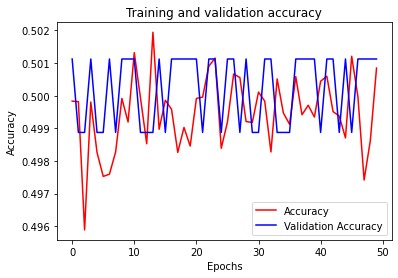

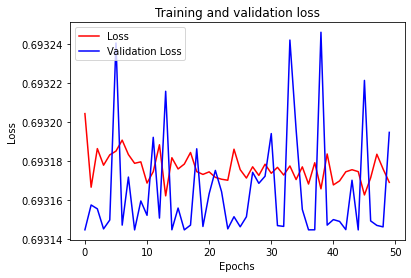

<Figure size 432x288 with 0 Axes>

In [11]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()

# Expected Output
# A chart where the validation loss does not increase sharply!